# Using pipelines and other accuracy metrics tools

This page uses jared's 30 year bin data set, and focuses on accomplishing a few tasks: 

* Use pipelines to streamline the process of reducing features in the model
* Test the accuracy of the model using a number of metrics




In [0]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/alexei-clay/SCEC_2019/master/data/eqdata_expanded_30_year_intervals.csv')

In [87]:
df.head()

,Index,San Andreas (Carrizo) rev,San Andreas (Cholame) rev,San Andreas (Mojave S),San Andreas (Coachella) rev,San Jacinto (Anza) rev,Garlock (West),Singles 0,Singles 1,Singles 2,Singles 3,Singles 4,Singles 5,Doubles 0,Doubles 1,Doubles 2,Doubles 3,Doubles 4,Doubles 5,Doubles 6,Doubles 7,Doubles 8,Doubles 9,Doubles 10,Doubles 11,Doubles 12,Doubles 13,Doubles 14,Triples 0,Triples 1,Triples 2,Triples 3,Triples 4,Triples 5,Triples 6,Triples 7,Triples 8,Triples 9,Triples 10,Triples 11,Triples 12,Triples 13,Triples 14,Triples 15,Triples 16,Triples 17,Triples 18,Triples 19,Quads 0,Quads 1,Quads 2,Quads 3,Quads 4,Quads 5,Quads 6,Quads 7,Quads 8,Quads 9,Quads 10,Quads 11,Quads 12,Quads 13,Quads 14,Quints 0,Quints 1,Quints 2,Quints 3,Quints 4,Quints 5,Sixes 0
0,0,0,0,3,1,0,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,4,2,1,5,1,0,1,1,1,1,0,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0
2,2,2,0,5,3,2,6,0,1,0,1,1,1,0,0,0,0,0,0,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,3,0,1,0,4,3,7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,4,1,2,1,5,4,8,1,0,1,1,1,1,0,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0


In [88]:
df.shape

(33218, 70)

In [0]:
# For importing images
from IPython.display import Image
%matplotlib inline

In [120]:
from sklearn.preprocessing import LabelEncoder

# 1-x are the faults, 8 is the probability output column
X = df.iloc[:, 1:7].values
y = df.iloc[:, 8].values

# Label encoder isn't necessary for this notebook, i'm just messing around
le = LabelEncoder()

# If you had say a two classes labeled 'A' and 'B' respectively, you can change them with fit_transform
y = le.fit_transform(y)

le.classes_

array([0, 1])

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

### Check the number of features of the training and test sets


In [92]:
print('X_train.shape: ', X_train.shape)
print('X_test.shape: ', X_train.shape)
print('y_train.shape: ', X_train.shape)
print('y_test.shape: ', X_train.shape)

X_train.shape:  (26574, 6)
X_test.shape:  (26574, 6)
y_train.shape:  (26574, 6)
y_test.shape:  (26574, 6)


### Use transformers and estimators in the pipeline ( a streamlined way of using scikit-learn's PCA)

* Instead of going through the fitting and transformation steps for the training and test datasets separately, we can chain the StandardScaler, PCA, and LogisticRegression objects in a pipeline:




In [93]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1, solver='lbfgs'))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.896


# Begin Metrics Tools Section



The following taken from Jared's logistic regression analysis:

In [95]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.59      0.67      1165
           1       0.92      0.96      0.94      5479

    accuracy                           0.90      6644
   macro avg       0.84      0.77      0.80      6644
weighted avg       0.89      0.90      0.89      6644



## K-fold cross validation 

basic idea: 
* split the data **randomnly** into 'k-holds', without replacement 
* gets split with each iteration 
* at each iteration, one of the splits (or folds) is used for training, and the other fold is used for performance evaluation
* process gets repeated k times, and you end up with k evaluation metrics

In [119]:
Image(url="https://raw.githubusercontent.com/rasbt/python-machine-learning-book-2nd-edition/master/code/ch06/images/06_03.png", width=500)

In [96]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
    

kfold = StratifiedKFold(n_splits=10,
                        random_state=1).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [ 4192 19724], Acc: 0.900
Fold:  2, Class dist.: [ 4192 19724], Acc: 0.905
Fold:  3, Class dist.: [ 4192 19724], Acc: 0.895
Fold:  4, Class dist.: [ 4192 19724], Acc: 0.895
Fold:  5, Class dist.: [ 4192 19724], Acc: 0.913
Fold:  6, Class dist.: [ 4192 19724], Acc: 0.897
Fold:  7, Class dist.: [ 4192 19725], Acc: 0.902
Fold:  8, Class dist.: [ 4192 19725], Acc: 0.900
Fold:  9, Class dist.: [ 4193 19725], Acc: 0.904
Fold: 10, Class dist.: [ 4193 19725], Acc: 0.906

CV accuracy: 0.902 +/- 0.005


In [97]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.89992476 0.90519187 0.89503386 0.89541008 0.91271633 0.89653875
 0.90176891 0.89988709 0.90399096 0.90625   ]
CV accuracy: 0.902 +/- 0.005


# Finding overfitting and variance issues with a 'learning curve'

Sources - parts taken from PML: Sebastian Raschka

If the model is overly complex, and therefore is uncompatable with the data set (that is 'too many degrees of freedom' or features in the model), the model generally won't do well with unseen data.
 


* Control the absolute or relative number of training samples that are used to generate the learning curves. 

* Set train_sizes=np.linspace(0.1, 1.0, 10) to use 10 evenly spaced, relative intervals for the training set sizes. 

* By default, the learning_curve function uses stratified k-fold cross-validation to calculate the cross-validation accuracy of a classifier, and we set k=10 via the cv parameter for 10-fold stratified cross-validation. 

* Then, calculate the average accuracies from the returned cross-validated training and test scores




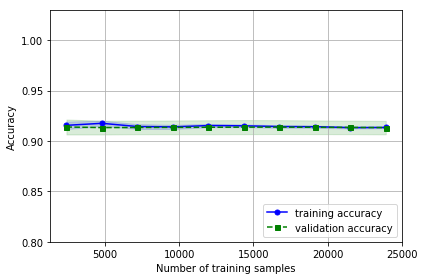

In [98]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1, solver='lbfgs'))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()



## Overfitting and underfitting with validation curves

Defintion of overfitting: 
* Overfitting occurs when a statistical model or machine learning algorithm captures the noise of the data. ... Overfitting is often a result of an excessively complicated model, and it can be prevented by fitting multiple models and using validation or cross-validation to compare their predictive accuracies on test data.


If you see that the training accuracy increases as the data set gets smaller, it's likely an indicator of overfitting

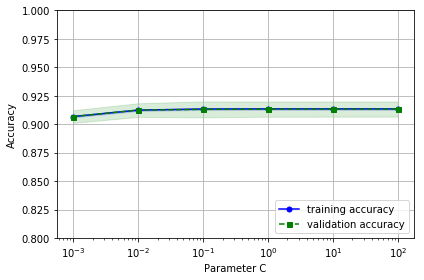

In [99]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

### Results: It appears the data has not been overfitted

### Output a 'confusion matrix'

#### Wiki: 

In the field of machine learning and specifically the problem of statistical classification, a confusion matrix, also known as an error matrix,[4] is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one (in unsupervised learning it is usually called a matching matrix). Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa).[2] The name stems from the fact that it makes it easy to see if the system is confusing two classes (i.e. commonly mislabeling one as another).



In [113]:
# Uncomment for a glossary of metrics definitions
# Image(url = "https://raw.githubusercontent.com/alexei-clay/SCEC_2019/master/images/metrics_definitions.PNG", width=400)

Image(url= "https://raw.githubusercontent.com/rasbt/python-machine-learning-book-2nd-edition/master/code/ch06/images/06_08.png",  width=300)

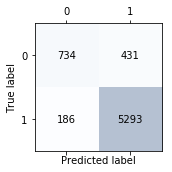

In [101]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

In [102]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[ 734  431]
 [ 186 5293]]


In [103]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.925
Recall: 0.966
F1: 0.945


# Plot a Receiver Operating Characteristic (ROC)

### Definition of an ROC: 
* A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.


### True Positive Rate (TPR) vs. False Positive Rate (FPR)

Good resource: 
* http://mlwiki.org/index.php/ROC_Analysis

ROC graphs are useful tools to select models based on their classication scores with TPR and FPR

The diagonal of an ROC can be thought of as **random guessing**

A perfect classifier would point to 100% TPR

In [116]:
Image(url = "https://raw.githubusercontent.com/alexei-clay/SCEC_2019/master/images/nterpretation-of-the-Receiver-Operating-Characteristic-ROC-space.png", width=300)

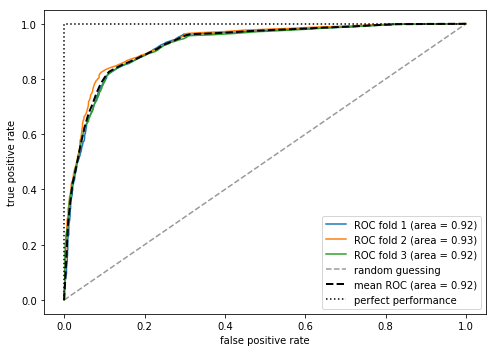

In [107]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1, 
                                           C=100.0, solver='lbfgs'))

X_train2 = X_train[:, [1, 5]]
    

cv = list(StratifiedKFold(n_splits=3, 
                          random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

## More notes on the ROC: 
